<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" height="300" width="700"> 
</center>

# <center> R для тервера и матстата <br>  <br> Ошибки, точные критерии, бутстрап </center>

In [9]:
library("ggplot2")  # Пакет для красивых графиков 
library("grid")     # Пакет для субплотов

# Отрегулируем размер картинок, которые будут выдаваться в нашей тетрадке
library('repr')
options(repr.plot.width=4, repr.plot.height=3)

## Задачулечка 1: про осьминога

Во время ЧЕ по футболу 2008 года и ЧМ 2010 года [Осьминог Пауль](https://ru.wikipedia.org/wiki/Пауль_(осьминог))занимался прогнозированием побед (после он ушёл в финансовую аналитику и IB). Осьминог дал верные прогнозы в $12$ случаях из $14$. Если предположить, что Пауль выбирает победителя наугад, какова вероятность получить 12 верных прогнозов из 14? 

Можно ли утверждать, что Осьминог обладает даром предвидения? Чётко опишите все предпосылки, которые используйте при проверке гипотезы, а также выбранный вами критерий. 

In [ ]:
    # ┬─┬ ノ( ゜-゜ノ)       Писать код самому? 
    
    # (╯° □°)╯︵ ┻━┻

## Задачулечка 2: бутстрап

Компания Verizon - основная региональная телекоммуникационная компания в западной части США. Она отвечает за поддержание наземной телефонной связи (Incumbent Local Exchange Carrier, ILEC). Кроме того, она продаёт услуги междугородней связи, как и ряд её конкурентов, получивших название (Competing Local Exchange Carriers, CLEC).

Когда что-то шло не так, Verizon отвечала за ремонт своего оборудования и оборудования конкурентов. Она должна была делать ремонт оборудования конкурентов также быстро, как и ремонт своего оборудования. За этим следила комиссия по коммунальным услугам. 

Периодически возникали подозрения, что Verizon ремонтирует чужое оборудование медленнее. Тим Хестерберг, автор [отличной статьи про бустрап,](https://arxiv.org/pdf/1411.5279.pdf) консультировал компанию Verizon во время слушаний о нарушениях. Комиссия сравнивала время ремонта для Verizon и других компаний. Чтобы определить есть ли нарушения, в каждом случае, она проверяла гипотезу о равенстве средних на уровне значимости $1\%$. 

Если более $1\%$ тестов оказывались значимыми, компания должна была бы заплатить высокий штраф. Гипотезы проверялись с помощью $t$-статистик. После консультации Тима, Verizon предложила использовать тесты, робастные к выбросам и никак не завязанные на нормальность исходных распределений.

Мы в этом задании попробуем ответить на тот же вопрос, связанный с дискриминацией, но с помощью бустрапа. Для этого мы построим доверительный интервал для разности медиан и посмотрим входит ли в него ноль. Будем использовать уровень значимости в $1\%$. Доверительный интервал будем строить для одной CLEC-комиании и для Verizon. 

In [4]:
library('dplyr')
library('rio') # тут import, который сам догадается до разделителей и даже excel прочтёт

df = import('verizon.txt')

# ILEC - внутренний клиент 
# CLEC - внешние клиенты 
head(df)

Time,Group
17.50,ILEC
2.40,ILEC
0.00,ILEC
0.65,ILEC
22.23,ILEC
1.20,ILEC


В данных есть существенный перекос в количестве наблюдений. Среднее время ремонта CLEC почти вдвое больше, чем для ILEC. Вопрос в том, является ли это свидетельством дискриминации. Если посмотреть на распределение, можно заметить, что распределение времени на ремонт CLEC имеет как минимум один выброс. Тем не менее, если смотреть на медианы, которые робастны (нечувствительны) к выбросам, ситуация, связанная со временем оказывается ещё более драмматичной. 

In [5]:
df %>% group_by(Group) %>% 
summarise(count = n(), mean = mean(Time), median = median(Time))

Group,count,mean,median
CLEC,23,16.509130,14.33
ILEC,1664,8.411611,3.59


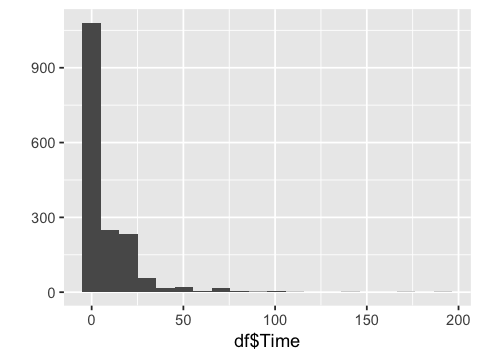

In [10]:
qplot(df$Time, bins=20)

In [13]:
df %>% sample_n(size = 3, replace=TRUE)

Time,Group
5.18,ILEC
2.37,ILEC
0.00,ILEC


__а)__ Постройте для разницы $med_{CLEC} - med_{Verizion}$ доверительный интервал Эфрона (перцентильный доверительный интервал). 

- Бутсрапируем: оценку неизвестного параметра
- Сэмплируем: $x_1^{*}, \ldots, x_n^{*}$
- Считаем: $\hat{\theta}^{*}$
- Повторяем: $B$ раз
- Строим распределение: $\hat{\theta}^{*}_1, \ldots, \hat{\theta}^{*}_B$
- Доверительный интервал: $[\hat{\theta}^{*}_{\frac{\alpha}{2}}; \hat{\theta}^{*}_{1 - \frac{\alpha}{2}}]$

> Если распределение выборки несимметрично, такой доверительный интервал усиливает смещение, присущее изначальной выборке.

Сделали подвыборку размера $3$ с повторениями, потом по ней можно что-нибудь посчитать. Например, медианы. Закодим бустрап в виде двух функций. Первая будет делать `B_sample` выборок.

In [14]:
B_sample = 10**4  # количество бустрэп-выборок

In [18]:
get_bootstrap_samples <- function(df, B_sample){
    
    N = nrow(df)      # размер каждой выборки
    sample = rep(0,B_sample) # сюда буду записывать медианы

    for(i in 1: B_sample){
        # генерируем выборки с повторениями соответствующую по размерам оригинальной  
        # и записываем её в лист
        df_boot = df %>% sample_n(size = N, replace=TRUE)
        sample[i] =  median(df_boot$Time)
    }
    return(sample)
}

In [22]:
# одна выборка из трёх сбутстрапированных медиан
get_bootstrap_samples(df, 3)

[1] 3.5 3.6 3.5

Вторая функция будет искать квантили сгерированого распределения. 

In [23]:
stat_intervals <- function(stat, alpha){
    return(quantile(stat, c(alpha/2, (1 - alpha/2)), name = FALSE))
    }

Отделим данные по внутренним и внешним клиентам друг от друга и построим доверительные интервалы для каждой из медиан. Будем бустрапировать $10000$ выборок. 

In [24]:
ilec = df %>% filter(Group == 'ILEC')
ilec_median_scores = get_bootstrap_samples(ilec, 10000)
ilec_median_scores[1:10]

[1] 3.380 3.625 3.500 3.380 3.500 3.700 3.720 3.770 3.650 3.675

In [25]:
clec = df %>% filter(Group == 'CLEC')
clec_median_scores = get_bootstrap_samples(clec, 10000)
clec_median_scores[1:10]

[1] 14.13  5.45 17.97 20.00 19.88  8.60 14.13 14.13  8.33 18.57

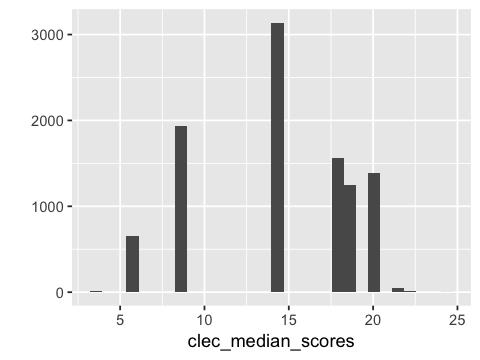

In [26]:
qplot(clec_median_scores,bins = 30)

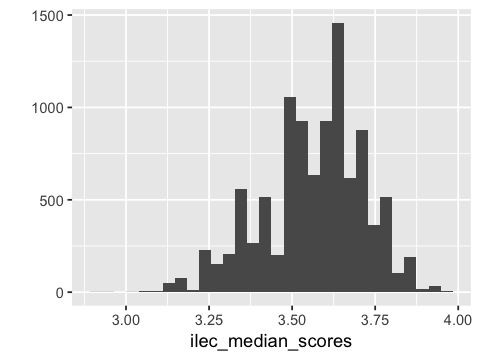

In [27]:
qplot(ilec_median_scores, bins = 30)

In [28]:
cat("95% confidence interval for the ILEC median repair time:", stat_intervals(ilec_median_scores, 0.05),'\n')
cat("95% confidence interval for the CLEC median repair time:", stat_intervals(clec_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: 3.22 3.835 
95% confidence interval for the CLEC median repair time: 5.8 20

По аналогии найдём доверительный интервал для разности медиан. 

In [29]:
delta_median_scores = clec_median_scores - ilec_median_scores
cat("95% confidence interval for the diff median repair time:", stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the diff median repair time: 2.07 16.64012

В целом, перцентильный интервал выглядит самым простым вариантом оценивания, однако в реальности он даёт весьма плохие результаты, так как сильно зависит от того насколько хорошо изначальная выборка аппроксимирует истинное распределение случайной величины. В данной ситуации из-за того, что исходное распределение асимметрично, мы получаем смещение.

__б)__ Постройте для разницы $med_{CLEC} - med_{Verizion}$ доверительный интервал Холла (обратный перцентильный доверительный интервал). 

- Бутсрапируем: оценку неизвестного параметра
- Сэмплируем: $x_1^{*}, \ldots, x_n^{*}$
- Считаем: $\hat{q}^{*} = \hat{\theta}^{*} - \hat{\theta}$
- Повторяем: $B$ раз
- Строим распределение: $\hat{q}^{*}_1, \ldots, \hat{q}^{*}_B$
- Доверительный интервал: $[\hat{\theta} - \hat{q}^{*}_{\frac{\alpha}{2}}; \hat{\theta} - \hat{q}^{*}_{1 - \frac{\alpha}{2}}]$

> Холл в своей работе называл перцентильный интервал "the wrong pivot, backwards". Обратный перцентильный интервал для асимметричных распределений делает то же самое, но в обратном направлении.

__в)__ Постройте $t-$ перцентильный доверительный интервал:

- Бутсрапируем: t-статистику
- Сэмплируем: $x_1^{*}, \ldots, x_n^{*}$
- Считаем: $t^{*} = \frac{\hat{\theta}^{*} - \hat{\theta}}{se^{\hat{\theta}^*}}$
- Повторяем: $B$ раз
- Строим распределение: $t^{*}_1, \ldots, t^{*}_B$
- Доверительный интервал: $[\hat{\theta} - t^{*}_{1 - \frac{\alpha}{2}} \cdot se(\hat{\theta}); \hat{\theta} - t^{*}_{\frac{\alpha}{2}}\cdot se(\hat{\theta})]$


__Алгоритм для этой задачи:__

1. Найдите точечную оценку неизвестного параметра (разность медиан) и точечную оценку стандартного отклонения
2. Сгенерируйте $10^5$ boostrap-выборок
3. Рассчитайте по каждой выбооке выборочную разницу медиан 
4. Рассчитайте по каждой выборке стандартную ошибку 
5. Найдите по каждой выборке $$t^* = \frac{\hat \theta^{*} - \hat{\theta}}{S^{*}}$$
6. Найдите для $t^{*}$ квантили уровня $0.05$ и $0.995$
7. Постройте доверительный интервал для разности медиан

В качестве $S^{*}$ исполизуйте сумму стандартных отклонений, посчитанных по выборкам $x$ и $y$. Конечно же, мы используем при таком подходе неправильное стандартное отклонение. При этом мы надеемся, что бутсрэп сам поправит нашу ошибку. При таком подходе главное, чтобы знаменатель сходился по вероятности к какому-нибудь пределу.

Можно генерировать стандартное отклонение с помощью двойного бустрапа, но это уже другая история. 

In [38]:
get_bootstrap_samples <- function(df, B_sample){
    
    N = nrow(df)      # размер каждой выборки
    sample = rep(0,B_sample) # сюда буду записывать медианы
    sd_sample = rep(0,B_sample)

    for(i in 1: B_sample){
        # генерируем выборки с повторениями соответствующую по размерам оригинальной  
        # и записываем её в лист
        df_boot = df %>% sample_n(size = N, replace=TRUE)
        sample[i] =  median(df_boot$Time)
        sd_sample[i] = sd(df_boot$Time)
    }
    return(list('med'=sample, 'sd'=sd_sample))
}

In [42]:
ilec_median_scores = get_bootstrap_samples(ilec, 10000)
clec_median_scores = get_bootstrap_samples(clec, 10000)

In [51]:
med_hat = median(clec$Time) - median(ilec$Time)
sd_hat = sd(df$Time)

ilec_med = ilec_median_scores$med
ilec_sd = ilec_median_scores$sd

clec_med = clec_median_scores$med
clec_sd = clec_median_scores$sd

sd = ilec_sd + clec_sd
diff = clec_med - ilec_med

t = (diff - med_hat)/sd

In [58]:
q = quantile(t, c(0.025, 0.975))
q1 = q[[1]]
q2 = q[[2]]

In [59]:
med_hat - q2*sd_hat

[1] 7.370135

In [60]:
med_hat - q1*sd_hat

[1] 15.90141

> У $t$-bootstrap есть одно интересное свойство: он "уважает" асимметрию распределений при расчёте доверительных интервалов. [Теория показывает,](http://quantile.ru/03/03-SA.pdf) что последний способ даёт более низкую ошибку в плане асимптотики. 

## Почиташки:

* [Статья про бустрэп от Анатольева,](http://quantile.ru/03/03-SA.pdf) она немного брутальная из-за регрессий и тп. Саму статью вы не поймёте, но в конце неё есть ссылки на то, что можно почитать на более простом уровне и углубиться в тему. 
* [Годная статейка про бутстрап в R](https://moderndive.com/8-confidence-intervals.html) да и вообще книжка про статистику в R неплохая